# Building makemore Part 2: MLP

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [ ]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
len(words)

32033

In [ ]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [ ]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
# for w in words[:5]:
for w in words:
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    # print(ix)
    X.append(context)
    # print(X)
    Y.append(ix)
    # print(Y)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
X = torch.tensor(X)
Y = torch.tensor(Y)

In [ ]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [ ]:
Y

tensor([ 5, 13, 13,  ..., 26, 24,  0])

In [ ]:
# for each one of 27 chars, give 2 dimensional embedding
C = torch.randn((27, 2))

In [ ]:
# cast to float becase the one_hot outputs long type,
# and C is float
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-0.4713,  0.7868])

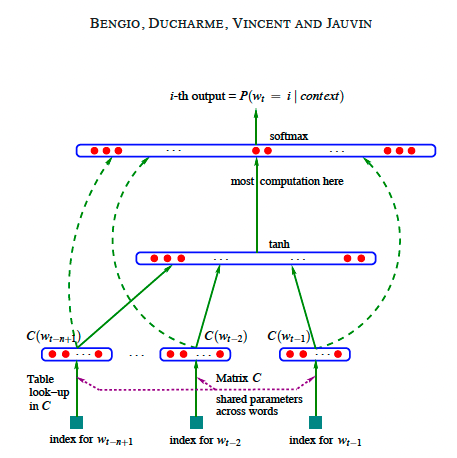

In [ ]:
# this embedding can be seen as:
# 1. the integer indexing into a lookup table C, or
# 2. the first layer having liner neurons with weights matrix C
# embed all integers in X, can simply use:
emb = C[X]
emb.shape


torch.Size([32, 3, 2])

In [ ]:
# let's set the num of neurons 100
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [ ]:
# transform [32, 3, 2] to [32, 6]
# # method1, but what if we change block_size
# torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]], 1).shape
# # method2, no matter block_size, much less efficient
# torch.cat(torch.unbind(emb, 1),1).shape
# method3,use view, much efficient
# see http://blog.ezyang.com/2019/05/pytorch-internals/
# h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [ ]:
h

tensor([[-0.9516,  0.0602, -0.9992,  ..., -1.0000, -0.9999,  0.9987],
        [-0.9590,  0.9394, -0.9932,  ..., -0.9987, -1.0000,  0.9997],
        [-0.9815,  0.9445, -0.7581,  ..., -0.9988, -0.3479,  0.9999],
        ...,
        [ 0.9920, -0.6481, -0.7058,  ...,  1.0000, -0.9364,  0.5318],
        [-0.6171,  0.9982, -0.7497,  ...,  0.9900,  0.9680,  0.7448],
        [ 0.7692,  0.9880, -0.9877,  ...,  0.7290,  0.9831, -0.7852]])

In [ ]:

# a = torch.arange(18)
# a.view(2, 3,3)
# a.storage()


In [ ]:
# final layer
# inputs 100 neurons, outputs 27
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [ ]:
logits = h @ W2 + b2

In [ ]:
logits.shape

torch.Size([32, 27])

In [ ]:
counts = logits.exp()
# normalize to prob
prob = counts / counts.sum(1, keepdims=True)

In [ ]:
prob.shape

torch.Size([32, 27])

In [ ]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(17.3967)

In [ ]:
# ------------ now made respectable :) ---------------

In [ ]:
X.shape, Y.shape # dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [ ]:
# init
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [ ]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

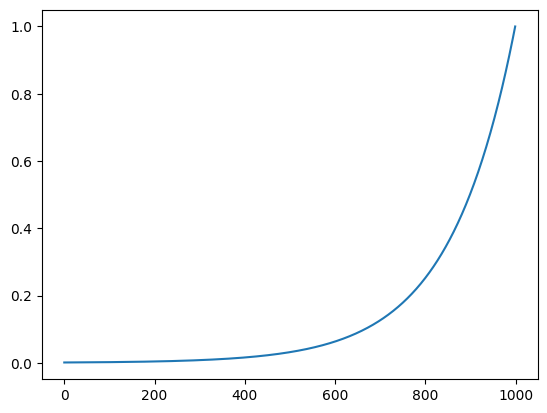

In [ ]:
plt.plot(lrs)

In [ ]:
# determine the initial learning rate
# 1. manually set a wide range of rates to get a sense,
# 0.001 ~ 1 looks good
# 2. generate a thousand rates within the range, but exponentially
# 3. run the optimization for 1000 steps, using the learning rates indexed,
# and keep tracking of the loss
# 4. plot the stats to find a good spot for a learning rate

In [ ]:
# for p in parameters:
#     p.requires_grad = True


# lri = []
# lossi = []

# for i in range(1000):

#   # minibatch construct
#   ix = torch.randint(0, X.shape[0], (32,))

#   # forward pass
#   emb = C[X[ix]] # (32, 3, 2)
#   h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
#   logits = h @ W2 + b2 # (32, 27)
#   loss = F.cross_entropy(logits, Y[ix])
#   # the above line is equivalent to the following 3 lines, but much more efficient
#   # counts = logits.exp()
#   # prob = counts / counts.sum(1, keepdims=True)
#   # loss = -prob[torch.arange(32), Y].log().mean()
#   # call cross_entropy() is much more efficient, in terms of:
#   # 1. forward pass and backward pass can be much more efficient,
#   # 2. more numerically well behaved, as large positve numbers in logits
#   # are handled.
#   # print(loss.item())

#   # backward pass
#   for p in parameters:
#     p.grad = None
#   loss.backward()

#   # update
#   lr = lrs[i]
#   for p in parameters:
#     p.data += -lr * p.grad

#   # track stats
#   lri.append(lre[i])
#   lossi.append(loss.item())


# # print(loss.item())


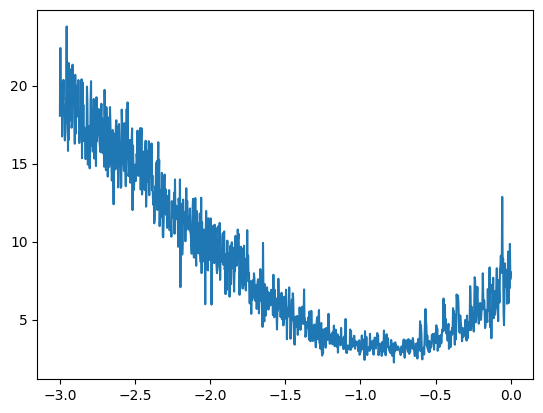

In [ ]:
plt.plot(lri, lossi)
# so 0.1 is a good initial learning rate

In [ ]:
for p in parameters:
    p.requires_grad = True


lri = []
lossi = []

for i in range(10000):

  # minibatch construct
  ix = torch.randint(0, X.shape[0], (32,))

  # forward pass
  emb = C[X[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Y[ix])
  # the above line is equivalent to the following 3 lines, but much more efficient
  # counts = logits.exp()
  # prob = counts / counts.sum(1, keepdims=True)
  # loss = -prob[torch.arange(32), Y].log().mean()
  # call cross_entropy() is much more efficient, in terms of:
  # 1. forward pass and backward pass can be much more efficient,
  # 2. more numerically well behaved, as large positve numbers in logits
  # are handled.
  # print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  # lr = lrs[i]
  lr = 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # # track stats
  # lri.append(lre[i])
  # lossi.append(loss.item())


# print(loss.item())


In [ ]:
# forward pass
# for the whole dataset
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)
loss

# already better than the bigram model which was 2.5

tensor(2.3204, grad_fn=<NllLossBackward0>)

## training, dev/validation, test split

In [ ]:
# training split, dev/validation split, test split
# 80%, 10%, 10%
# test split is rarely used at the end, because if it's used a lot,
# as every time we learn something from it, it's equivelent to train on the test
# split

In [ ]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

# training set
Xtr, Ytr = build_dataset(words[:n1])
# dev set
Xdev, Ydev = build_dataset(words[n1:n2])
# test set
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
len(words), n1, n2

(32033, 25626, 28829)

In [ ]:
# init
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [ ]:
for p in parameters:
    p.requires_grad = True


lri = []
lossi = []
stepi = []


In [ ]:
for i in range(200000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  # the above line is equivalent to the following 3 lines, but much more efficient
  # counts = logits.exp()
  # prob = counts / counts.sum(1, keepdims=True)
  # loss = -prob[torch.arange(32), Y].log().mean()
  # call cross_entropy() is much more efficient, in terms of:
  # 1. forward pass and backward pass can be much more efficient,
  # 2. more numerically well behaved, as large positve numbers in logits
  # are handled.
  # print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  # lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  # lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())


# print(loss.item())


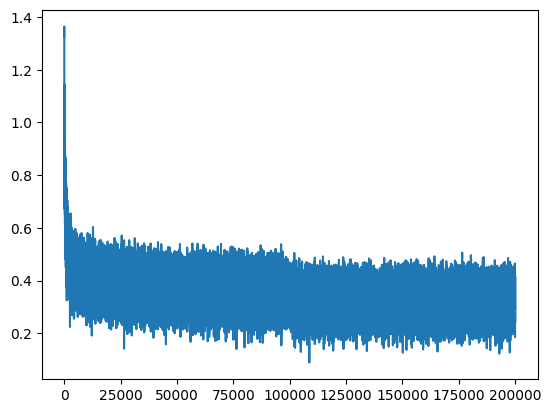

In [ ]:
plt.plot(stepi, lossi)

In [ ]:
print(loss.item())

1.87509024143219


In [ ]:
# forward pass
# for the whole dataset
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

# already better than the bigram model which was 2.5

tensor(2.1291, grad_fn=<NllLossBackward0>)

In [ ]:
# forward pass
# for the whole dataset
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

# already better than the bigram model which was 2.5

tensor(2.1664, grad_fn=<NllLossBackward0>)

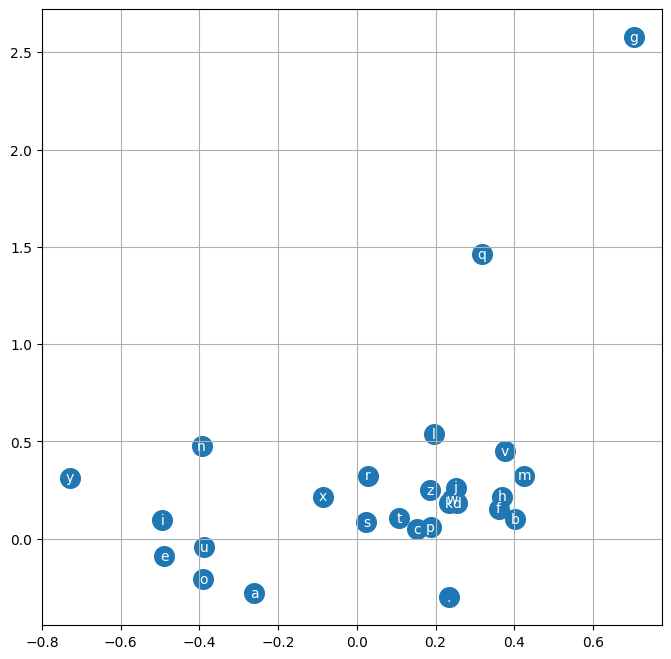

In [ ]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
## nobs to try:
# 1. increase the nn size, the num of neurons in the hidden layer
# 2. increase the dimensionality of the embedding lookup table C
# 3. incease the n of ngram
# 4. fine tune: steps, learning rate, batch size
# more options in the paper

In [ ]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

eria.
kayanniee.
med.
ryah.
remmadiendraeg.
adeeko.
elin.
shi.
jenne.
elisson.
arleigh.
malara.
nosadhvis.
himie.
trick.
welle.
jeten.
fin.
zence.
ryyah.
